<a href="https://colab.research.google.com/github/szulcmaciej/colab-notebooks/blob/main/LSTM_on_generated_sequences.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from tensorflow import keras
import random
from keras.preprocessing.sequence import TimeseriesGenerator

Using TensorFlow backend.


# Data generation

In [ ]:
NUM_SEQUENCES = 100000
SEQUENCE_MIN_LENGTH = 3
SEQUENCE_MAX_LENGTH = 30
MUTATION_PROB = 0.3
ACTIONS = list(range(20))

In [ ]:
sequences = []
np.random.seed(12345)
for i in range(NUM_SEQUENCES):
  seq = [0]
  np.random.seed(i*123)
  seq_length = np.random.randint(SEQUENCE_MIN_LENGTH, SEQUENCE_MAX_LENGTH + 1)
  # seq_length = 20

  # linear
  seq = list(range(seq_length))

  # sinus
  # seq = list(map(lambda idx, x: x + np.floor(3 * np.sin(idx)), seq))
  seq = [min(SEQUENCE_MAX_LENGTH, max(0, x + np.floor(3 * np.sin(0.5 * idx + i)))) for idx, x in enumerate(seq)]

  # randomness
  # for j in range(len(seq) - 1):
  #     np.random.seed(j*i*12+123*i+10*j)
  #     if np.random.rand() < MUTATION_PROB:
  #       seq[j], seq[j+1] = seq[j+1], seq[j]
    
  sequences.append(np.array(seq))

In [ ]:
sequences[:4]

[array([ 0.,  2.,  4.,  5.,  6.,  6.,  6.,  5.,  5.,  6.,  7.,  8., 11.,
        13., 15.]),
 array([ 2.,  3.,  4.,  4.,  4.,  3.,  3.,  4.,  5.,  6.,  9., 11., 13.,
        15., 16., 17.]),
 array([2., 2., 2., 1., 1., 2., 3.]),
 array([ 0.,  0.,  0.,  0.,  1.,  2.,  5.,  7.,  9., 11., 12., 13., 13.,
        12., 12., 12., 13.])]

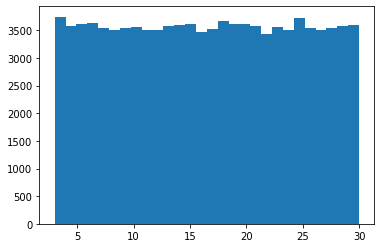

In [ ]:
plt.hist(list(map(len, sequences)), bins=28);

In [ ]:
### padding sequences
sequences_from_1 = list(map(lambda x: x + 1, sequences))
padded_sequences = keras.preprocessing.sequence.pad_sequences(sequences_from_1, padding='post')

In [ ]:
# data_gen = TimeseriesGenerator(X, X,
#                                length=10, sampling_rate=2, 
#                                batch_size=2)

In [ ]:
padded_sequences.shape

(100000, 30)

In [ ]:
X = np.array(padded_sequences)[:,:-1]
# X = np.array(padded_sequences).reshape((*padded_sequences.shape, 1))[:,:-1,:]

In [ ]:
X.shape

(100000, 29)

In [ ]:
y = np.array(padded_sequences)[:,1:]
# y = np.array(padded_sequences).reshape((*padded_sequences.shape, 1))[:,1:,:]

In [ ]:
y.shape

(100000, 29)

In [ ]:
# X[:5, :, :]

In [ ]:
# y[0]

# Model

In [ ]:
from keras.callbacks import LambdaCallback
from keras.models import Sequential
from keras.layers import Dense, TimeDistributed, LSTM, Embedding
from keras.utils import to_categorical
from tensorflow.keras.optimizers import RMSprop

In [ ]:
# model = Sequential()

# model.add(LSTM(32, return_sequences=True, input_shape=(None, 1)))
# model.add(LSTM(8, return_sequences=True))
# model.add(TimeDistributed(Dense(20, activation='softmax')))

# model.compile(loss='categorical_crossentropy',
#               optimizer='adam')

# def train_generator():
#     while True:
#         sequence_length = np.random.randint(10, 100)
#         x_train = np.random.random((10, sequence_length, 1))
#         # y_train will depend on past 5 timesteps of x
#         y_train = x_train[:, :, 0].copy()
#         for i in range(1, 5):
#             y_train[:, i:] += x_train[:, :-i, 0]
#         y_train = to_categorical(y_train > 2.5, num_classes=20)
#         yield x_train, y_train

# model.fit_generator(train_generator(), steps_per_epoch=30, epochs=10, verbose=1)

In [ ]:
y_categorical = to_categorical(y)
# y_categorical = to_categorical(y, SEQUENCE_MAX_LENGTH+1)
y_categorical.shape

(100000, 29, 32)

In [ ]:
model = Sequential()

model.add(Embedding(input_dim=32, output_dim=16, mask_zero=True))
model.add(LSTM(32, return_sequences=True, input_shape=(None, 1)))
# model.add(LSTM(64, return_sequences=True))
model.add(LSTM(8, return_sequences=True))
model.add(TimeDistributed(Dense(y_categorical.shape[2], activation='softmax')))
# model.add(Dense(20, activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['acc'])

In [ ]:
# %%timeit -n 1 -r 1
history = model.fit(X, y_categorical, batch_size=512, epochs=100, validation_split=0.3)

Train on 70000 samples, validate on 30000 samples
Epoch 1/100
70000/70000 [==============================] - 25s 356us/step - loss: 3.1205 - acc: 0.0831 - val_loss: 2.6982 - val_acc: 0.1566
Epoch 2/100
70000/70000 [==============================] - 17s 247us/step - loss: 2.4497 - acc: 0.2188 - val_loss: 2.2530 - val_acc: 0.2760
Epoch 3/100
70000/70000 [==============================] - 17s 250us/step - loss: 2.1280 - acc: 0.2901 - val_loss: 2.0241 - val_acc: 0.3143
Epoch 4/100
70000/70000 [==============================] - 17s 247us/step - loss: 1.9326 - acc: 0.3508 - val_loss: 1.8462 - val_acc: 0.3923
Epoch 5/100
70000/70000 [==============================] - 17s 249us/step - loss: 1.7782 - acc: 0.4261 - val_loss: 1.7173 - val_acc: 0.4671
Epoch 6/100
70000/70000 [==============================] - 18s 251us/step - loss: 1.6683 - acc: 0.4863 - val_loss: 1.6225 - val_acc: 0.5068
Epoch 7/100
70000/70000 [==============================] - 17s 248us/step - loss: 1.5839 - acc: 0.5177 - val_l

In [ ]:
# loss: 0.2927 - acc: 0.9009 - val_loss: 0.2915 - val_acc: 0.9015

In [ ]:
#%%timeit -n 1 -r 1
history2 = model.fit(X, y_categorical, batch_size=128, epochs=1000, validation_split=0.3)

Train on 70000 samples, validate on 30000 samples
Epoch 1/1000
70000/70000 [==============================] - 66s 943us/step - loss: 0.5271 - acc: 0.8235 - val_loss: 0.5210 - val_acc: 0.8254
Epoch 2/1000
70000/70000 [==============================] - 66s 939us/step - loss: 0.5206 - acc: 0.8261 - val_loss: 0.5165 - val_acc: 0.8280
Epoch 3/1000
70000/70000 [==============================] - 67s 956us/step - loss: 0.5177 - acc: 0.8275 - val_loss: 0.5355 - val_acc: 0.8208
Epoch 4/1000
70000/70000 [==============================] - 66s 943us/step - loss: 0.5162 - acc: 0.8287 - val_loss: 0.5115 - val_acc: 0.8299
Epoch 5/1000
70000/70000 [==============================] - 66s 946us/step - loss: 0.5149 - acc: 0.8290 - val_loss: 0.5171 - val_acc: 0.8298
Epoch 6/1000
70000/70000 [==============================] - 66s 946us/step - loss: 0.5124 - acc: 0.8297 - val_loss: 0.5073 - val_acc: 0.8313
Epoch 7/1000
70000/70000 [==============================] - 67s 956us/step - loss: 0.5113 - acc: 0.8299 

In [ ]:
# Plot training & validation accuracy values
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

NameError: ignored

In [ ]:
# Plot training & validation accuracy values
plt.plot(history2.history['acc'])
plt.plot(history2.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [ ]:
single_prediction = model.predict(X[9:10])

In [ ]:
single_prediction = single_prediction.reshape(single_prediction.shape[1], single_prediction.shape[2])

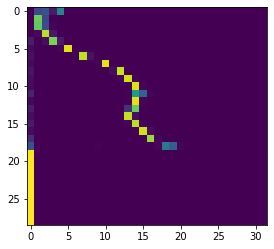

In [ ]:
plt.imshow(single_prediction)

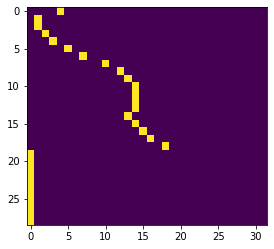

In [ ]:
# plt.imshow(np.max(single_prediction))
# np.argmax(single_prediction, axis=1)
plt.imshow(to_categorical(np.argmax(single_prediction, axis=1), y_categorical.shape[2]))

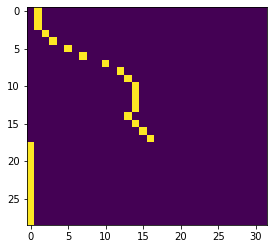

In [ ]:
plt.imshow(y_categorical[9])

In [ ]:
model.evaluate(X, y_categorical)

1000/1000 [==============================] - 1s 728us/step


[3.154971733093262, 0.47951724004745483]

In [ ]:
y_categorical[0]

array([[0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.

In [ ]:
gen = train_generator()
sample = next(gen)
sample[0].shape, sample[1].shape

((10, 88, 1), (10, 88, 20))

In [ ]:
sample[0][0].shape

In [ ]:
sample[0][0,:,0]

In [ ]:
plt.imshow(sample[0][0])

In [ ]:
plt.imshow(sample[1][0])